In [3]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import Counter
from scipy import stats
import ast
import matplotlib.pyplot as plt
from operator import itemgetter

# Scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import urllib.request, urllib.parse
import time
from datetime import datetime


## CNN

In [1]:
headlines, dates, bodies, urls = [], [], [], []

In [ ]:
pagenum = 1
url = f'https://search.api.cnn.io/content?size={size}&q=coronavirus,covid&page={pagenum}&sort=newest&from={(pagenum-1)*size}'
json_data = requests.get(url).json()
data = json_data['result']

In [ ]:
query = "coronavirus"
query = "covid" #6000 results

In [ ]:
# Collect the URLs
for pagenum in range(1,60): 
    url = f'https://search.api.cnn.io/content?size={size}&q={query}&page={pagenum}&sort=newest&from={(pagenum-1)*size}'
    json_data = requests.get(url).json()
    data = json_data['result']

    for d in data:
        headlines.append(d['headline'])
        dates.append(d['firstPublishDate'])
        bodies.append(d['body'])
        urls.append(d['url'])


In [ ]:
cnn = pd.DataFrame.transpose(pd.DataFrame([headlines, dates, urls, bodies]))
cnn.columns = ['title','date', 'url', 'text']

In [ ]:
cnn.to_csv('data/raw_data/cnn.csv')

## Fox

In [ ]:
# https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-50.php
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [ ]:
dates = []
start_dt = date(2020, 1, 1)
end_dt = date(2020, 6, 23)
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%Y%m%d"))

daterange = []
for i in range(len(dates)-1):
    daterange.append((int(dates[i]), int(dates[i+1])))

In [ ]:
titles = []
links = []

# query="coronavirus"
query="covid"

In [ ]:
# Get the links
for date in daterange:
    for page in range(0,10): 
        startdate, enddate = date
        print(startdate, enddate)
        url = f"https://api.foxnews.com/search/web?q={query}+more:pagemap:metatags-pagetype:article+more:pagemap:metatags-dc.type:Text.Article&siteSearch=foxnews.com&siteSearchFilter=i&sort=date:r:{startdate}:{enddate}&start={page*10}&callback=__jp{page+1}"

        req = requests.get(url)
        t = re.findall(r'\s"og:title":\s"(.*)"',req.text)
        urls = re.findall(r'\s"link":\s"(.*)"',req.text)
        titles.extend(t)
        links.extend(urls)
        print(page, len(t), len(urls))
        
        if len(t) < 10:
            break
        
#         time.sleep(5)

In [ ]:
# Get the text
bodies = []
dates = []

index = 1
for url in links[1677:]:
    print(index)
    index += 1
    req = urllib.request.Request(url)

    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml')
    
    if not ("radio" in url or "video" in url or "watch/" in url or "c/brooke-crothers" in url 
            or "shows/ingraham" in url or "w-abby-hornacek" in url) :
        date = soup.find("div", attrs = {"class": "article-date"}).text
        date = re.match(r'Published\s(.*)', date).group(1)
        dates.append(date)
        a = soup.find("div", attrs = {"class": "article-body"})
        text = [b.text for b in a.findAll("p")]
        bodies.append(text)
    else:
        bodies.append("NA")
        dates.append("NA")
        

In [188]:
len(titles), len(links), len(dates), len(bodies)

(3120, 3120, 3120, 3120)

In [ ]:
fox = pd.DataFrame.transpose(pd.DataFrame([titles, dates, links, bodies]))
fox.columns = ['title','date', 'url', 'text']

In [ ]:
# Fix the dates
# https://stackoverflow.com/questions/47246143/changing-relative-times-to-actual-dates-in-a-pandas-dataframe

fox.date = fox.date.astype(str) + ' 2020'
absolute_date = pd.to_datetime(fox.date, errors="coerce")
relative_date = (datetime.today() - 
                 fox.date.str.extract("(.*) ago", expand=False).apply(pd.Timedelta))

date = relative_date.combine_first(absolute_date)


fox.date = date.dt.date

In [ ]:
fox.to_csv("data/raw_data/fox_covid.csv")

## NYT

In [ ]:
# https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-50.php
from datetime import timedelta, date

def get_dates_in_range(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


In [ ]:
dates = []
start_dt = date(2020, 1, 1)
end_dt = date(2020, 6, 25)
for dt in get_dates_in_range(start_dt, end_dt):
    dates.append(dt.strftime("%Y%m%d"))

# Date range of 5 days
daterange = []
for i in range(0, len(dates)-5, 5):
    daterange.append((int(dates[i]), int(dates[i+5])))

In [ ]:
titles, dates, urls = [], [], []
apikey = "I1EX29cHWoOBYDsre22OfzeTkxYujx0B"

query = "coronavirus"
# query = "covid"

In [ ]:
for date in daterange:
    
    count = 0
    for page in range(100):
        startdate, enddate = date
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&sort=best&begin_date={startdate}&end_date={enddate}&page={page}&api-key={apikey}'
        print(url)
        time.sleep(5)
        req = requests.get(url)
        
        while (req.status_code != 200):
            print("Trying again")
            time.sleep(10)
            req = requests.get(url)

        
        if (len(req.json()['response']['docs']) == 0):
            break
        
        print("num hits", req.json()['response']['meta']['hits'])
        print(startdate, enddate)
        
        for j in req.json()['response']['docs']:
            titles.append(j['headline']['main'])
            dates.append(j['pub_date'])
            urls.append(j['web_url'])

In [311]:
len(titles), len(dates), len(urls)

(21711, 21711, 21711)

In [312]:
nyt = pd.DataFrame.transpose(pd.DataFrame([titles, dates, urls]))
nyt.columns = ['title', 'date','url']
nyt

,title,date,url
0,China Identifies New Virus Causing Pneumoniali...,2020-01-09T02:48:29+0000,https://www.nytimes.com/2020/01/08/health/chin...
1,China Reports First Death From New Virus,2020-01-11T01:41:56+0000,https://www.nytimes.com/2020/01/10/world/asia/...
2,Japan and Thailand Confirm New Cases of Chines...,2020-01-16T03:29:27+0000,https://www.nytimes.com/2020/01/15/world/asia/...
3,China Reports First Death From New Virus,2020-01-11T01:41:56+0000,https://www.nytimes.com/2020/01/10/world/asia/...
4,The Coronavirus: What Scientists Have Learned ...,2020-01-21T20:06:18+0000,https://www.nytimes.com/article/what-is-corona...
...,...,...,...
21706,Atlanta Mourns Rayshard Brooks in a Sanctuary ...,2020-06-23T17:35:36+0000,https://www.nytimes.com/2020/06/23/us/rayshard...
21707,The Second Defeat of Bernie Sanders,2020-06-23T09:00:22+0000,https://www.nytimes.com/2020/06/23/opinion/ber...
21708,PGA Tour's Monahan Warns Players After Positiv...,2020-06-24T20:22:46+0000,https://www.nytimes.com/reuters/2020/06/24/spo...
21709,Florida Election Results: Live Presidential Pr...,2020-06-24T17:36:20+0000,https://www.nytimes.com/interactive/2020/03/17...


In [ ]:
# REMOVE DUPLICATES
nyt.drop_duplicates(inplace=True)
nyt["keyword"] = query

nyt.reset_index(inplace=True, drop=True)

In [ ]:
for index, row in nyt.iterrows():
    print(index, row.url)
    req = urllib.request.Request(row.url)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml')

    # date = soup.find("time")["datetime"]
    a = soup.find("section", attrs={"name": "articleBody"})
    if a:
        body = ' '.join([c.text for c in a.findAll("p")][:-3])
        nyt.loc[index, 'body'] = body
    
    time.sleep(5)


In [ ]:
nyt.to_csv(f"data/nyt_{query}.csv")

## Washington Post

There were too many to scrape all in one go so I had to do them in batches


In [2]:
urls = []

In [ ]:
for start in range(0, 3000, 100):

    if start == 0: url = "https://sitesearchapp.washingtonpost.com/sitesearch-api/v2/search.json?count=500&datefilter=displaydatetime:%5B*+TO+NOW%2FDAY%2B1DAY%5D&facets.fields=%7B!ex%3Dinclude%7Dcontenttype,%7B!ex%3Dinclude%7Dname&highlight.fields=headline,body&highlight.on=true&highlight.snippets=1&query=contact+tracing&sort=&startat=1&callback=angular.callbacks._0"
    else:          url = f"https://sitesearchapp.washingtonpost.com/sitesearch-api/v2/search.json?count=500&datefilter=displaydatetime:%5BNOW%2FDAY-1YEAR+TO+NOW%2FDAY%2B1DAY%5D&facets.fields=%7B!ex%3Dinclude%7Dcontenttype,%7B!ex%3Dinclude%7Dname&highlight.fields=headline,body&highlight.on=true&highlight.snippets=1&query=contact+tracing&sort=&startat={start}&callback=angular.callbacks._0"

    req = urllib.request.Request(url)

    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html, 'lxml')

    c = re.findall(r'https://www.washingtonpost.com(.*?)"', soup.text)
    print(start, len(c))

    urls.extend(["https://www.washingtonpost.com" + b for b in c])

In [ ]:
titles = []
dates = []
bodies = []

In [ ]:
for url in urls:
    # url = "https://www.washingtonpost.com/national/contact-tracing-is-best-tool-we-have-until-theres-a-vaccine-say-health-experts/2020/06/13/94f42ffa-a73b-11ea-bb20-ebf0921f3bbd_story.html"

    if "video" in url:
        title = "NA"
        date = "NA"
        body = "NA"
    else:
        try:
            req = urllib.request.Request(url)
            html = urllib.request.urlopen(req).read()
            soup = BeautifulSoup(html, 'lxml')

            title = soup.find("h1").text

            d = soup.find("div", attrs={"class": "display-date"})
            if d:
                date = d.text
            else:
                d = soup.find("span", attrs={"class": "author-timestamp"})
                if d:
                    date = d["content"]
                else: date = "NA"

            body = ' '.join([b.text for b in soup.findAll("p")])

        except:
            body = 'NA'
            date = 'NA'
            title = 'NA'


    print(index, title, date)
    bodies.append(body)
    titles.append(title)
    dates.append(date)

    index += 1
    time.sleep(1)


In [ ]:
wp = pd.DataFrame.transpose(pd.DataFrame([titles, dates, urls, bodies]))
wp.columns = ['title', 'date','url', 'text']
wp.drop_duplicates(inplace=True)
wp.to_csv(f"data/raw_data/washingtonpost{range_end}.csv")

### Then, Concat

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
wp_csvs = ["data/raw_data/"+f for f in listdir("data/raw_data") if ".csv" in f]
dfs = [pd.read_csv(a) for a in wp_csvs]

In [ ]:
null_urls = df[df.text.isnull()].url.values
print(len(null_urls))

In [ ]:
# Drop the null values
df = pd.concat(dfs)
df = df[df.date.notna()]
df = df[df.text.notna()]

df.reset_index(drop=True, inplace=True)
df.drop(columns="Unnamed: 0", inplace=True)


In [ ]:
# Fix the dates
df['date2'] = pd.to_datetime(df.date, errors="coerce")
a = df[df['date2'].isnull()].date.str.extract("(.*)T", expand=False)
df.loc[a.index, "date2"] = a.values

df[df['date2'].isnull()]

df['date'] = pd.to_datetime(df['date2'], utc=True).dt.date
df.drop(columns="date2", inplace=True)

In [ ]:
df.to_csv("data/raw_data/washingtonpost.csv")

## Merging

In [ ]:
nyt = pd.read_csv(f"{PATH}/nyt.csv")
nyt["source"] = "nyt"
fox = pd.read_csv(f"{PATH}/fox.csv")
fox["source"] = "fox"
breit = pd.read_csv(f"{PATH}/breitbart.csv")
breit["source"] = "breitbart"
cnn = pd.read_csv(f"{PATH}/cnn.csv")
cnn["source"] = "cnn"
wp = pd.read_csv(f"{PATH}/wp.csv")
wp["source"] = "wp"
dc = pd.read_csv(f"{PATH}/dailycaller.csv")
dc["source"] = "daily caller"

nyt.rename(columns={"body": "text"}, inplace=True)

In [ ]:
# Fix dailycaller dates
# correct_dailycaller_dates = [re.search(r"\d\d\d\d/\d\d/\d\d", a).group() for a in dc.url.values]
# df.loc[df.source=="daily caller", 'date'] = correct_dailycaller_dates
# df['date'] = pd.to_datetime(df['date'], utc=True).dt.date

In [ ]:
def clean_fox(text):
    res = re.search(r'\[(.*)\]', text) # Remove text in square brackets
    ea = eval(res.group(1))
    st = ' '.join([a for a in ea])
    cleaned = re.sub(r'\b[A-Z]+\b', '', st) # Remove ALL caps
    cleaned = re.sub("Fox News Flash top headlines are here. Check out what's clicking on Foxnews.com.", '', cleaned)
    return cleaned

In [ ]:
fox['text'] = fox['text'].map(lambda x: clean_fox(x))

In [ ]:
df = pd.concat([nyt, fox, breit, cnn, wp, dc])

In [ ]:
df.drop(columns="Unnamed: 0", inplace=True)
df['date'] = pd.to_datetime(df['date'], utc=True).dt.date
df.reset_index(drop=True, inplace=True)

len(df)

In [ ]:
len(df[df['date'].isnull()]), len(df[df['text'].isnull()])

In [ ]:
# Null things. not a lot so i'll just drop them
print("Num null text items:", len(df[df.text.isnull()]))

df = df[df.text.notnull()]
len(df)

Num null text items: 9


61661

In [ ]:
len(df[df['date'].isnull()]), len(df[df['text'].isnull()])

(0, 0)

In [ ]:
df.sort_values(by="date", inplace=True)

# Drop the things before 2020-01-01
df = df.loc[df.date > pd.to_datetime("2020-01-01").date()]
df.reset_index(inplace=True, drop=True)
len(df)

In [ ]:
df.to_pickle("data/us_news_raw.pkl")

# Clean, Tokenize, Lemmatize

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt') # tokenizer
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords;
from nltk.tokenize import word_tokenize
STOPWORDS = stopwords.words("english")

# stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
STOPWORDS.extend(["said", "also", "would", "like"] )

In [4]:
df = pd.read_pickle("data/us_news_raw.pkl")

In [5]:
def clean_text(text):
    remove_char = string.punctuation + '…' + '\xa0' + '·' + '\n' + \
        '※' + '‘' + '’' + '\'' + '▲' + '∼' + "△" + "“" + "”" + "▶" + "․" + \
        "▸"
    text = re.sub('http[s]?://\S+', '', text) # Remove http urls
    text = re.sub('\S*@\S*\s?', '', text) # Remove emails
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(remove_char), '', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub('\'', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.lower()


In [ ]:
df['clean_text'] = df['text'].map(lambda x: clean_text(x))

In [ ]:
# Number mentioning "contact tracing"
contact_tracing = df[df.text.str.contains("contact tracing|contact-tracing|contact tracking|contact-tracking")]
len(contact_tracing)

In [6]:
def preprocess(text):
    result = []
    for token in word_tokenize(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token))
    return result

In [ ]:
# Tokenize and remove stopwords (this takes a while)
df['text_proc_token'] = df['clean_text'].map(preprocess)


In [ ]:
df['text_proc'] = df['text_proc_token'].apply(lambda a: ' '.join(a))

df.head()

,title,date,url,keyword,text,source,clean_text,text_proc_token,text_proc
0,Official Says 121 Countries Have Asked South K...,2020-01-04,https://dailycaller.com/2020/04/01/countries-a...,NaN,121 countries have asked South Korea for novel...,daily caller,countries have asked south korea for novel co...,"[country, asked, south, korea, novel, coronavi...",country asked south korea novel coronavirus te...
1,How China’s Mystery Pneumonia Illness is Diffe...,2020-01-07,https://www.washingtonpost.com/business/how-ch...,coronavirus,An outbreak of pneumonia in central China is c...,wp,an outbreak of pneumonia in central china is c...,"[outbreak, pneumonia, central, china, causing,...",outbreak pneumonia central china causing alarm...
2,Upgrade your home workout with this top-rated ...,2020-01-08,https://www.cnn.com/2020/01/08/cnn-underscored...,coronavirus,While the past few weeks have seen us all star...,cnn,while the past few weeks have seen us all star...,"[past, week, seen, start, continuously, saniti...",past week seen start continuously sanitize eve...
3,Specter of possible new virus emerging from ce...,2020-01-08,https://www.washingtonpost.com/world/asia_paci...,coronavirus,BEIJING — An outbreak of an unidentified and p...,wp,beijing — an outbreak of an unidentified and p...,"[beijing, outbreak, unidentified, possibly, vi...",beijing outbreak unidentified possibly viral d...
4,How China’s Mystery Pneumonia Illness is Diffe...,2020-01-09,https://www.washingtonpost.com/business/how-ch...,coronavirus,A mysterious outbreak of pneumonia in central ...,wp,a mysterious outbreak of pneumonia in central ...,"[mysterious, outbreak, pneumonia, central, chi...",mysterious outbreak pneumonia central china ca...


In [ ]:
# More cleaning
df.text_proc = df.text_proc.str.replace("contact tracking", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracking", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact tracked", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact track", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact tracer", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact trace", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracer", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracing", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttrace", "contact tracing")


In [ ]:
### TO DO : fix daily caller dates :0 
dailycaller = pd.read_csv(f"{PATH}/old/dailycaller.csv")
correct_dailycaller_dates = [re.search(r"\d\d\d\d/\d\d/\d\d", a).group() for a in dailycaller.url.values]
df.loc[df.source=="daily caller", 'date'] =  pd.to_datetime(correct_dailycaller_dates, utc=True).date


In [ ]:
df = df.drop_duplicates('text_proc')
df.reset_index(drop=True, inplace=True)
len(df)

51541

In [ ]:
df.to_pickle("data/us_proc.pkl")

# Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

In [10]:
df = pd.read_pickle("data/us_proc.pkl")

## Helper Functions

In [ ]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
# https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
def document_topic_matrix(model, data, n_components):
    # column names
    topicnames = ["Topic" + str(i) for i in range(n_components)]
    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model, 2), columns=topicnames, index=docnames)
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    return df_document_topic

In [ ]:
def topic_keyword_matrix(model, vectorizer):
    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(model.components_)
    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    topicnames = ["Topic" + str(i) for i in range(n_components)]

    df_topic_keywords.index = topicnames
    # View
    df_topic_keywords.head()
    return df_topic_keywords

In [ ]:
def topic_keyword_matrix(model, vectorizer):
    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(model.components_)
    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    topicnames = ["Topic" + str(i) for i in range(n_components)]

    df_topic_keywords.index = topicnames
    # View
    df_topic_keywords.head()
    return df_topic_keywords

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [ ]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = vectors[row_id].T.todense()
    return top_tfidf_feats(row, features, top_n)

## Run LDA

In [ ]:
contact_tracing = df[df.text_proc.str.contains("contact tracing")]

In [ ]:
num_articles = len(df)
# num_articles = 10000 # This is for a small subset for playing around

documents = [''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].source

n_components = 500

In [ ]:
nmf = NMF(n_components=n_components, random_state=1, init='nndsvd')
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df = 0.8, ngram_range = (2,2), lowercase=False, max_features=5000)
tfidf_vectors = tfidf_vectorizer.fit_transform(documents)

In [ ]:
# CHECK: Make sure that contact tracing exists in the vectorizer's feature names
"contact tracing" in tfidf_vectorizer.get_feature_names() 

In [ ]:
%time nmf_tfidf_vec = nmf.fit_transform(tfidf_vectors)

CPU times: user 1h 18min 18s, sys: 1min 8s, total: 1h 19min 26s
Wall time: 1h 23min 34s


In [ ]:
vocab = np.array(tfidf_vectorizer.get_feature_names())
num_top_words = 50
nmf_topics = show_topics(nmf.components_, vocab, num_top_words)

In [ ]:
# TO SAVE
# with open(f'{PATH}/models/nmf_vectorizer_bigrams.pk', 'wb') as fin:
#     pickle.dump(tfidf_vectorizer, fin)
# with open(f'{PATH}/models/nmf_vectors_bigrams.pk', 'wb') as fin:
#     pickle.dump(tfidf_vectors, fin)
# with open(f'{PATH}/models/nmf_tfidf_vec_bigrams.pk', 'wb') as fin:
#     pickle.dump(nmf_tfidf_vec, fin)

# with open('{PATH}/models/nmf_topics.txt', "w") as fin: 
#     fin.write(nmf_topics) 

# Node List

In [4]:
# TO LOAD
with open(f'models/nmf_vectorizer_bigrams.pk', 'rb') as file:
    vectorizer = pickle.load(file)
with open(f'models/nmf_vectors_bigrams.pk', 'rb') as file:
    vectors = pickle.load(file)
with open(f'models/nmf_tfidf_vec_bigrams.pk', 'rb') as file:
    vec = pickle.load(file)

/usr/local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
topics = pd.read_csv('models/nmf_topics.txt', sep=",", header=None)[0]

In [11]:
num_articles = len(df)
documents = [''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].source
n_components = 500

In [12]:
# Build the document-topic matrix
# https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

topicnames = ["Topic" + str(i) for i in range(n_components)]
docnames = ["Doc" + str(i) for i in range(len(documents))] # Index names
doc_top_matrix = pd.DataFrame(np.round(vec, 3), columns=topicnames, index=docnames)
mean = doc_top_matrix.apply(lambda row: np.mean(row.values[np.nonzero(row.values)]),axis=1)
median = doc_top_matrix.apply(lambda row: np.median(row.values[np.nonzero(row.values)]),axis=1)
doc_top_matrix["mean"] = mean
doc_top_matrix["median"] = median

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
doc_top_matrix

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic492,Topic493,Topic494,Topic495,Topic496,Topic497,Topic498,Topic499,mean,median
Doc0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.002,0.0,0.000,0.010158,0.0030
Doc1,0.000,0.023,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.017,0.000,0.0,0.0,0.000,0.008,0.0,0.000,0.011600,0.0035
Doc2,0.002,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.010320,0.0020
Doc3,0.000,0.013,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.001,0.001,0.0,0.000,0.006805,0.0020
Doc4,0.000,0.022,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.015,0.000,0.0,0.0,0.000,0.007,0.0,0.000,0.010773,0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc51536,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.001,0.002727,0.0010
Doc51537,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.001,0.0,0.000,0.014905,0.0020
Doc51538,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.011750,0.0060
Doc51539,0.000,0.000,0.0,0.194,0.001,0.0,0.0,0.0,0.0,0.0,...,0.013,0.001,0.0,0.0,0.000,0.000,0.0,0.000,0.014783,0.0020


Plot the distribution of one document

0.010157894736842105


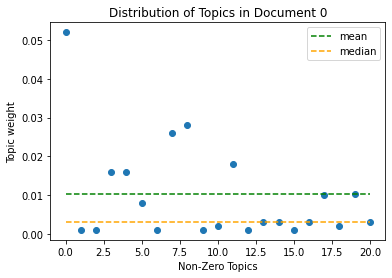

In [20]:
doc  = doc_top_matrix.loc['Doc0'].values
print
fig,ax = plt.subplots()

vals = np.nonzero(doc)
x = range(0,len(doc[vals]))

mean = doc[-2]
median = doc[-1]
print(mean)
means = [mean]*len(doc[vals])
medians = [median]*len(doc[vals])

ax.scatter(range(0,len(doc[vals])), doc[vals])
ax.plot(x, means, linestyle='--', color="green", label="mean")
ax.plot(x, medians, linestyle="--", color="orange", label="median")
ax.set_title("Distribution of Topics in Document 0")


ax.legend()

plt.xlabel("Non-Zero Topics")
plt.ylabel("Topic weight")
plt.show()

In general, it seems like mean is higher than median ... For now, will use mean for a more stringent cut-off. If this seems to be choking off the Contact Tracing topic, then I can resort to using the median.

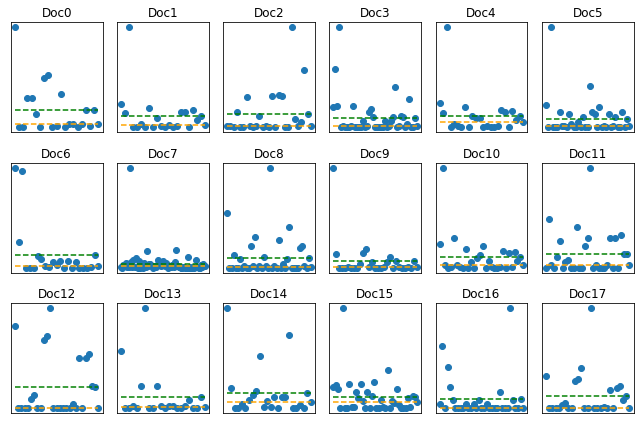

In [ ]:
grid = np.random.rand(4, 4)
docs = [f"Doc{a}" for a in range(18)]

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, docname in zip(axs.flat, docs):
    doc  = doc_top_matrix.loc[docname].values
    vals = np.nonzero(doc)
    x = range(0,len(doc[vals]))

    mean = [doc[-2]]*len(doc[vals])
    median = [doc[-1]]*len(doc[vals])

    ax.scatter(range(0,len(doc[vals])), doc[vals])
    ax.plot(x, mean, linestyle='--', color="green")
    ax.plot(x, median, linestyle="--", color="orange")
    ax.set_title(docname)

plt.tight_layout()
plt.show()

In [ ]:
doc_top_matrix.to_csv("/proc/doc_top_matrix.csv")

Discretize the topic-document matrix so that those above the mean cutoff are mapped to 1, 0 otherwise

In [ ]:
def discretize(row):
    if pd.notnull(row['mean']):
        row[row < row['mean']] = 0
        row[row >= row['mean']] = 1
        return row.astype(int)
    else: 
        return row
        

In [ ]:
discrete_dtm = doc_top_matrix.copy().apply(lambda row: discretize(row), axis=1)

In [ ]:
discrete_dtm = discrete_dtm.fillna(0)

In [ ]:
discrete_dtm = discrete_dtm.astype(int)

In [ ]:
discrete_dtm

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic492,Topic493,Topic494,Topic495,Topic496,Topic497,Topic498,Topic499,mean,median
Doc0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
Doc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc51536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc51537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc51538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Doc51539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
discrete_dtm.drop(columns=["mean", "median"], inplace=True)


In [ ]:
sums = discrete_dtm.sum(axis=0)[:-1]
discrete_dtm['source'] = sources.values

In [ ]:
discrete_dtm.to_csv("/proc/discrete_dtm.csv")

In [ ]:
node_list = discrete_dtm.groupby('source').sum().T

In [ ]:
node_list

source,breitbart,cnn,daily caller,fox,nyt,wp
Topic0,2,8,0,3,5138,1
Topic1,0,0,0,0,0,13434
Topic2,0,2,0,0,1,4600
Topic3,391,795,5,157,663,1096
Topic4,1,0,0,0,0,1
...,...,...,...,...,...,...
Topic495,44,178,1,31,186,190
Topic496,31,137,0,4,205,128
Topic497,178,451,6,95,381,342
Topic498,45,198,0,14,297,220


In [ ]:
node_list["totalcount"] = sums.values
node_list["label"] = topics.values

# Change the order
node_list = node_list[["label", "totalcount", "breitbart", "cnn", "fox", "nyt", "wp"]]

In [ ]:
node_list.label = node_list.label.apply(lambda row: [re.search("\w+", a).group(0) for a in row.split()])

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
node_list

source,label,totalcount,breitbart,cnn,fox,nyt,wp
Topic0,"[paid, leave, unemployment, rate, surface, sea...",5152,2,8,3,5138,1
Topic1,"[important, news, editor, delivered, signing, ...",13434,0,0,0,0,13434
Topic2,"[case, death, update, coronavirus, live, updat...",4603,0,2,0,1,4600
Topic3,"[oval, office, travel, europe, address, nation...",3107,391,795,157,663,1096
Topic4,"[white, house, house, official, trump, white, ...",2,1,0,0,0,1
...,...,...,...,...,...,...,...
Topic495,"[rhode, island, york, jersey, jersey, connecti...",630,44,178,31,186,190
Topic496,"[finance, minister, economic, fallout, economi...",505,31,137,4,205,128
Topic497,"[across, world, across, globe, people, across,...",1453,178,451,95,381,342
Topic498,"[video, call, video, conferencing, zoom, call,...",774,45,198,14,297,220


In [ ]:
node_list.sort_values(by="totalcount", ascending=False).head(30)

source,label,totalcount,breitbart,cnn,fox,nyt,wp
Topic1,"[important, news, editor, delivered, signing, ...",13434,0,0,0,0,13434
Topic74,"[president, trump, trump, called, pandemic, pr...",8871,968,822,611,2248,4220
Topic23,"[donald, trump, president, donald, trump, pres...",6926,1741,2947,118,781,1313
Topic0,"[paid, leave, unemployment, rate, surface, sea...",5152,2,8,3,5138,1
Topic7,"[coronavirus, pandemic, caused, coronavirus, o...",4842,783,1488,260,1102,1205
Topic2,"[case, death, update, coronavirus, live, updat...",4603,0,2,0,1,4600
Topic134,"[million, people, nearly, million, infected, m...",4554,396,1067,246,1468,1373
Topic275,"[number, people, large, number, people, infect...",3853,406,949,231,1049,1217
Topic156,"[spread, virus, contain, spread, curb, spread,...",3788,480,928,245,883,1251
Topic64,"[vice, president, former, vice, president, bid...",3585,309,771,130,737,1635


In [ ]:
node_list.loc["Topic75"]

source
label         [contact, tracing, apple, google, testing, con...
totalcount                                                 1438
breitbart                                                   109
cnn                                                         349
fox                                                          69
nyt                                                         322
wp                                                          589
Name: Topic75, dtype: object

In [ ]:
node_list.reset_index(inplace=True)
node_list.rename(columns={"index": "topic", "source": "index"}, inplace=True)

In [ ]:
node_list.to_csv("proc/us_nodelist.csv")

# Edge List

In [ ]:
from itertools import combinations
from collections import OrderedDict 

In [ ]:
df = pd.read_pickle("data/us_proc.pkl")
doc_top_matrix = pd.read_csv("/proc/doc_top_matrix.csv")
discrete_dtm = pd.read_csv("/proc/discrete_dtm.csv")

In [ ]:
def get_weekday(num):
    # https://docs.python.org/3/library/datetime.html#datetime.date.isocalendar
    if num == 1: return "Monday"
    if num == 2: return "Tuesday"
    if num == 3: return "Wednesday"
    if num == 4: return "Thursday"
    if num == 5: return "Friday"
    if num == 6: return "Saturday"
    if num == 7: return "Sunday"

In [ ]:
def get_political(source):
    """
    Returns true if liberal, false if conservative
    """
    if source in ["cnn", "wp" ,"nyt"]:
        return "liberal"
    else: return "conservative"

In [ ]:
def choose(n, k):
    # https://stackoverflow.com/questions/3025162/statistics-combinations-in-python/3025194#3025194
    """
    A fast way to calculate binomial coefficients by Andrew Dalke (contrib).
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [ ]:
new_columns = discrete_dtm.columns.values
discrete_dtm.columns = new_columns

In [ ]:
# Number of topics in each document
num_topics_per_document_list = discrete_dtm.sum(axis=1).values

# Figure out combinations space
num_combinations = sum([choose(a, 2) for a in num_topics_per_document_list[:-1]])


In [ ]:
num_combinations

1709368

In [ ]:
# Then pre-allocate that much space for the df that will hold the edge list
columns = ["node1", "node2", "documentId", "date", "day_of_week", "week_of_year", "month", "newssource", "political"]
edgelist = pd.DataFrame(columns=columns, index=range(num_combinations))


In [ ]:
discrete_dtm['num_topics_in_document'] = num_topics_per_document_list

In [ ]:
i = 0
for index, row in discrete_dtm.iterrows():
    print(index)
    if row.num_topics_in_document > 1:
#         print(row.num_topics_in_document)
        
        documentId = index#int(re.search('\d+', index).group())
        document = df.loc[documentId] # fetch document
        newssource = document.source
        political = get_political(newssource)
        
        date = document.date
#         print(document.source)
        _, week_of_year, day_of_week = date.isocalendar()
        month = document.date.month
        day_of_week = get_weekday(day_of_week)
        
        topic_combinations = combinations(row.index[row == 1], 2)
        
        for node1, node2 in topic_combinations:
#             print(node1, node2)
            
            onerow = pd.Series({"node1": node1, "node2": node2, "documentId": documentId, 
                                "date": date, "day_of_week": day_of_week, "week_of_year": week_of_year,
                                "month": month, "newssource": newssource, "political": political})
            
            edgelist.iloc[i] = onerow
            i += 1


In [ ]:
edgelist

,node1,node2,documentId,date,day_of_week,week_of_year,month,newssource,political
0,Topic23,Topic68,0,2020-01-24,Friday,4,1,daily caller,conservative
1,Topic23,Topic80,0,2020-01-24,Friday,4,1,daily caller,conservative
2,Topic23,Topic167,0,2020-01-24,Friday,4,1,daily caller,conservative
3,Topic23,Topic170,0,2020-01-24,Friday,4,1,daily caller,conservative
4,Topic23,Topic203,0,2020-01-24,Friday,4,1,daily caller,conservative
...,...,...,...,...,...,...,...,...,...
1709363,Topic54,Topic393,51539,2020-05-11,Monday,20,5,daily caller,conservative
1709364,Topic54,Topic471,51539,2020-05-11,Monday,20,5,daily caller,conservative
1709365,Topic188,Topic393,51539,2020-05-11,Monday,20,5,daily caller,conservative
1709366,Topic188,Topic471,51539,2020-05-11,Monday,20,5,daily caller,conservative


In [ ]:
edgelist.loc[1000]

node1             Topic299
node2             Topic342
documentId              29
date            2020-01-20
day_of_week         Monday
week_of_year             4
month                    1
newssource              wp
political          liberal
Name: 1000, dtype: object

In [ ]:
edgelist.to_csv(f"proc/us_edgelist.csv")

In [ ]:
edgelist.to_pickle(f"proc/us_edgelist.pkl")


In [ ]:
# WEIGHTED EDGE LIST

In [ ]:
df_weight = edgelist[["node1", "node2"]]

In [ ]:
df_weight = df_weight.groupby(df_weight.columns.tolist(),as_index=False).size().reset_index().rename(columns={0:'weight'})

In [ ]:
df_weight[df_weight['weight'] > 1]

,node1,node2,weight
1,Topic0,Topic10,151
2,Topic0,Topic100,207
3,Topic0,Topic101,156
4,Topic0,Topic102,146
5,Topic0,Topic103,130
...,...,...,...
64094,Topic99,Topic275,2
64096,Topic99,Topic299,2
64098,Topic99,Topic308,4
64106,Topic99,Topic338,2


In [ ]:
df_weight.sort_values("weight", ascending=False, inplace=True)

In [ ]:
weights = df_weight.sort_values("weight", ascending=False).weight.values

(array([76., 17.,  4.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 557. ,  958.6, 1360.2, 1761.8, 2163.4, 2565. , 2966.6, 3368.2,
        3769.8, 4171.4, 4573. ]),
 <a list of 10 Patch objects>)

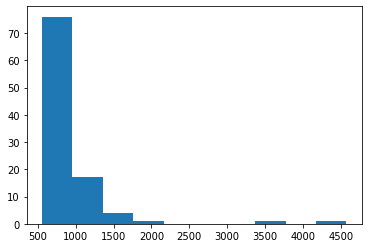

In [ ]:
plt.hist(weights[:100], bins = 10)

In [ ]:
df_weight[df_weight.node1 == "Topic75"].head()

,node1,node2,weight
57985,Topic75,Topic156,269
58092,Topic75,Topic275,267
57963,Topic75,Topic134,263
58110,Topic75,Topic299,258
57939,Topic75,Topic105,219


In [ ]:
df_weight[df_weight.node2 == "Topic75"].head()

,node1,node2,weight
731,Topic1,Topic75,457
57914,Topic74,Topic75,390
25056,Topic2,Topic75,266
33041,Topic24,Topic75,229
31297,Topic23,Topic75,201


In [ ]:
df_weight

,node1,node2,weight
445,Topic1,Topic2,4573
730,Topic1,Topic74,3485
710,Topic1,Topic54,1824
25055,Topic2,Topic74,1703
31296,Topic23,Topic74,1656
...,...,...,...
37491,Topic27,Topic79,1
37475,Topic27,Topic52,1
37474,Topic27,Topic50,1
37470,Topic27,Topic495,1


In [ ]:
df_weight.to_csv("proc/us_edgelist_weight.csv")

# Analysis

In [ ]:
# Topic seventyfive is contact tracing
seventyfive = edgelist[edgelist['node1'] == "Topic75"]
seventyfive = seventyfive.append(edgelist[edgelist['node2'] == "Topic75"])
seventyfive = seventyfive.sort_values(by="weight", ascending = False)

In [15]:
len(seventyfive)

370

In [ ]:
seventyfive

,node1,node2,weight
170,Topic1,Topic75,457
264,Topic74,Topic75,390
621,Topic75,Topic156,269
639,Topic75,Topic275,267
642,Topic2,Topic75,266
...,...,...,...
62193,Topic75,Topic493,1
62201,Topic75,Topic192,1
62224,Topic75,Topic143,1
62252,Topic75,Topic284,1


In [ ]:
nodelist_weighted = nodelist.sort_values(by="totalcount", ascending=False)
nodelist_weighted.reset_index(drop=False, inplace=True)

In [ ]:
nodelist_weighted[nodelist_weighted.topic == "Topic75"]

,index,topic,label,totalcount,breitbart,cnn,fox,nyt,wp
72,75,Topic75,"['contact', 'tracing', 'apple', 'google', 'tes...",1438,109,349,69,322,589


In [ ]:
nodelist_weighted

,index,topic,label,totalcount,breitbart,cnn,fox,nyt,wp
0,1,Topic1,"['important', 'news', 'editor', 'delivered', '...",13434,0,0,0,0,13434
1,74,Topic74,"['president', 'trump', 'trump', 'called', 'pan...",8871,968,822,611,2248,4220
2,23,Topic23,"['donald', 'trump', 'president', 'donald', 'tr...",6926,1741,2947,118,781,1313
3,0,Topic0,"['paid', 'leave', 'unemployment', 'rate', 'sur...",5152,2,8,3,5138,1
4,7,Topic7,"['coronavirus', 'pandemic', 'caused', 'coronav...",4842,783,1488,260,1102,1205
...,...,...,...,...,...,...,...,...,...
495,315,Topic315,"['postal', 'service', 'post', 'office', 'jeff'...",0,0,0,0,0,0
496,305,Topic305,"['remain', 'open', 'nonessential', 'business',...",0,0,0,0,0,0
497,392,Topic392,"['trump', 'administration', 'administration', ...",0,0,0,0,0,0
498,303,Topic303,"['every', 'year', 'year', 'since', 'time', 'ye...",0,0,0,0,0,0


In [ ]:
# Histogram of node weights

In [ ]:
weights = nodelist_weighted[nodelist_weighted.totalcount != 0]
weights = weights[weights.totalcount < 4000].totalcount.values

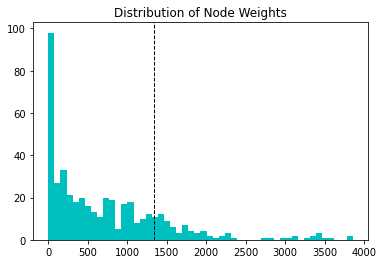

In [ ]:
result = plt.hist(weights, 50, color='c')
result = plt.axvline(1338, color='k', linestyle='dashed', linewidth=1)
result = plt.title("Distribution of Node Weights")


In [ ]:
e_weights = edgelist[edgelist.weight > 500]
e_weights = e_weights.weight.values

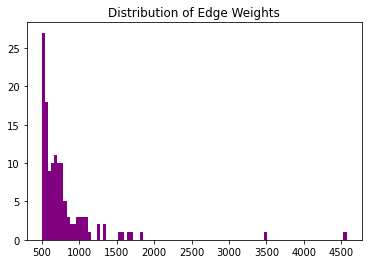

In [ ]:
result = plt.hist(e_weights, 100, color = 'purple')
# result = plt.axvline(1338, color='k', linestyle='dashed', linewidth=1)
result = plt.title("Distribution of Edge Weights")


In [ ]:
len(e_weights)

131

In [ ]:
# Identify all the edges containing the contact tracing node

seventyfive = edgelist[edgelist['node1'] == "Topic75"]
seventyfive = seventyfive.append(edgelist[edgelist['node2'] == "Topic75"])
seventyfive = seventyfive.sort_values(by="weight", ascending = False)

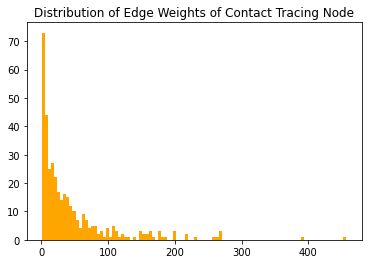

In [ ]:
result = plt.hist(seventyfive.weight.values, 100, color = 'orange')
# result = plt.axvline(1338, color='k', linestyle='dashed', linewidth=1)
result = plt.title("Distribution of Edge Weights of Contact Tracing Node")





In [ ]:
len(edgelist)

64120

In [ ]:
# percent of edges are above 100 weight
len(seventyfive[seventyfive.weight > 100]) / len(seventyfive)

0.12702702702702703

In [ ]:
len(seventyfive[seventyfive.weight > 200]) 

11

In [ ]:
len(seventyfive[seventyfive.weight > 20]) 

197

In [ ]:
# percent of edges are above 200 weight
len(edgelist[edgelist.weight > 400]) / len(edgelist) * 100

0.38365564566437926

In [ ]:
# percent of edges are above 100 weight
len(seventyfive[seventyfive.weight > 400]) / len(seventyfive) * 100

0.2702702702702703

In [ ]:
edgelist[edgelist.weight> 200]

,node1,node2,weight
0,Topic1,Topic2,4573
1,Topic1,Topic74,3485
2,Topic1,Topic54,1824
3,Topic2,Topic74,1703
4,Topic23,Topic74,1656
...,...,...,...
1090,Topic13,Topic105,201
1091,Topic134,Topic310,201
1092,Topic134,Topic205,201
1093,Topic136,Topic243,201


# Finding Articles to Analyze

In [5]:
threshold = 10

In [16]:
top_edges = seventyfive[seventyfive.weight>threshold]

In [17]:
top_edges

,node1,node2,weight
170,Topic1,Topic75,457
264,Topic74,Topic75,390
621,Topic75,Topic156,269
639,Topic75,Topic275,267
642,Topic2,Topic75,266
...,...,...,...
29169,Topic75,Topic231,11
28444,Topic75,Topic467,11
29043,Topic75,Topic295,11
29074,Topic75,Topic269,11


In [18]:
edgelist_full = pd.read_csv("models/us_edgelist.csv")

In [19]:
df = pd.read_pickle("data/us_proc.pkl")

In [ ]:
# For each of the 11 edges containing the contact tracing node, 
# and above an edge weight of 200, 
# All articles with those two topics

In [21]:
for index, row in top_edges.iterrows():
    # Find all the edges that include this specific edge
    edges = edgelist_full[(edgelist_full.node1 == row.node1) & (edgelist_full.node2 == row.node2)]
    
    # Get the document ids
    docIds = edges.documentId.values
    
    # Get the documents corresponding to these edges
    documents = df[df.index.isin(docIds)][["title", "date", "url", "keyword", "text", "source"]]
    documents.reset_index(inplace=True)
    
    textfile = f"[{len(edges)}]{row.node1}-{row.node2}.csv"
    print(textfile)
    
    documents.to_csv(f"texts_to_analyze_{threshold}/{textfile}")

[457]Topic1-Topic75.csv
[390]Topic74-Topic75.csv
[269]Topic75-Topic156.csv
[267]Topic75-Topic275.csv
[266]Topic2-Topic75.csv
[263]Topic75-Topic134.csv
[258]Topic75-Topic299.csv
[229]Topic24-Topic75.csv
[219]Topic75-Topic105.csv
[217]Topic75-Topic337.csv
[201]Topic23-Topic75.csv
[200]Topic75-Topic76.csv
[199]Topic75-Topic234.csv
[184]Topic75-Topic170.csv
[180]Topic75-Topic150.csv
[177]Topic75-Topic103.csv
[175]Topic54-Topic75.csv
[175]Topic75-Topic111.csv
[168]Topic75-Topic494.csv
[164]Topic75-Topic162.csv
[163]Topic75-Topic218.csv
[163]Topic75-Topic180.csv
[160]Topic75-Topic225.csv
[158]Topic75-Topic114.csv
[152]Topic0-Topic75.csv
[152]Topic75-Topic124.csv
[151]Topic75-Topic102.csv
[149]Topic75-Topic92.csv
[148]Topic75-Topic164.csv
[138]Topic75-Topic128.csv
[133]Topic75-Topic308.csv
[126]Topic75-Topic492.csv
[122]Topic22-Topic75.csv
[121]Topic75-Topic151.csv
[118]Topic75-Topic215.csv
[113]Topic75-Topic182.csv
[111]Topic7-Topic75.csv
[111]Topic75-Topic94.csv
[110]Topic34-Topic75.csv
[10

In [22]:
#  make a table of those 11 edges, including 
# a) the two node ids, 
# b) edge weight,
# c) bag of words for each node,

In [23]:
# get the list of nodes/topics
topics = list(set(list_flatten(top_edges[['node1', 'node2']].values.tolist())))

# dictionary mapping topic to name
topic_name_dict = nodelist[nodelist.topic.isin(topics)]
topic_name_dict["label"] = topic_name_dict.label.apply(lambda a: ast.literal_eval(a))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
node1_bow = []
node2_bow = []

for index, row in top_edges.iterrows():
    bow = topic_name_dict[topic_name_dict.topic == row.node1].label.values[0]
    node1_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    bow = topic_name_dict[topic_name_dict.topic == row.node2].label.values[0]
    node2_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    


In [ ]:
top_edges["node1_bow"] = node1_bow
top_edges["node2_bow"] = node2_bow

In [27]:
top_edges.to_csv(f"texts_to_analyze_{threshold}/top_edges_table.csv")